# HAR system - Lincetto Riccardo, Drago Matteo
This notebook runs:
- Classification with null class (One Shot classification);
- Binary classification for activity detection (Two Steps - detection);
- Classification without null class (Two Steps - classification);
- Cascade of the last two methods.

The operations performed here are very similar to those execute in 'main.py', with the exception that here the program is executed for specified user and model.

## Notebook setup
This first cell contains the parameters that can be tuned for code execution:
- subject: select the subject on which to test the model, between [1,4];
- task: choose "A" for locomotion classification or "B" for gesture recognition;
- model_name: choose between "Convolutional", "Convolutional1DRecurrent", "Convolutional2DRecurrent" and "ConvolutionalDeepRecurrent";
- data_folder: directory name where '.mat' files are stored;
- window_size: parameter that sets the length of temporal windows on which to perform the convolution;
- stride: step length to chose the next window;
- GPU: boolean flag indicatin wheter GPU is present on the machine that executes the code;
- epochs: number of complete sweeps of the data signals during training;
- batch_size: number of forward propagations in the networks between consecutives backpropagations;
- print_info: boolean flag to control displayed information.

In [6]:
subject = 1
task = "A"
model_name = "Convolutional"
data_folder = "./data/full/"
window_size = 15
stride = 5
GPU = True
epochs = 20
batch_size = 32
balance_classes = False
print_info = False

Here the useful functions are imported.

In [7]:
import launch
import preprocessing
import models
import utils
import os
import numpy as np
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from keras.models import load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.utils import to_categorical
import seaborn as sns
import matplotlib.pyplot as plt

Differently from 'main.py', all results saved from this notebook are going to be stored in a dedicated folder: './data/notebook/'. For proper execution, this folder needs first to be created.

In [8]:
if not(os.path.exists("./data")):
    os.mkdir("./data")
if not(os.path.exists("./data/notebook")):
    os.mkdir("./data/notebook")

If task A is selected, calssifications in the following notebook are based on the labels of column 0; if instead it's task B, column 6 labels are used.

In [9]:
if task == "A":
    label = 0
    classes = ["Inactive","Stand","Walk","Sit","Lie"]
elif task == "B":
    label = 6
    classes = ["Close Dishwasher","Close Drawer 3","Close Drawer 2","Inactive","Close Door 1","Close Door 2","Close Drawer 1","Close Fridge","Toggle Switch","Open Dishwasher","Open Drawer 3","Open Drawer 2","Open Door 1","Open Door 2","Open Drawer 1","Open Fridge","Drink from Cup","Clean Table"]
else:
    print("Error: invalid task.")
print("Task", task, "uses labels column", label)

Task A uses labels column 0


## Classification with null class: One Shot classification
Here classification is performed considering inactivity as a class, alongside with the others. In the case of locomotion classification (task A), this becomes a 5-class problem, while in the case of gesture recognition (task B) the classes become 18. In the following cell are perfomed in order:
- preprocessing;
- model selection;
- model compilation;
- training.

Note that in case "Convolutional2DRecurrent" is the model selected, then the preprocessed data need to be reshaped, adding one dimension; this is automatically done by the code inside 'launch.py'.

In [12]:
model, X_test, Y_test, filepath, save_model_name = launch.oneshot_classification(subject,
                                                                                 task,
                                                                                 model_name,
                                                                                 data_folder,
                                                                                 window_size=window_size,
                                                                                 stride=stride,
                                                                                 epochs=epochs,
                                                                                 batch_size=batch_size,
                                                                                 balcance_classes=balance_classes,
                                                                                 GPU=GPU,
                                                                                 print_info=print_info)

Model: A_Convolutional_OS_1 
Location: ./data/models/A_Convolutional_OS_1.hdf5 

Train on 31422 samples, validate on 11504 samples
Epoch 1/10
31422/31422 [==============================] - 12s 382us/step - loss: 0.5994 - acc: 0.8431 - val_loss: 0.4263 - val_acc: 0.8852

Epoch 00001: val_loss improved from inf to 0.42630, saving model to ./data/models/A_Convolutional_OS_1.hdf5
Epoch 2/10
31422/31422 [==============================] - 10s 330us/step - loss: 0.3243 - acc: 0.8822 - val_loss: 0.3869 - val_acc: 0.8939

Epoch 00002: val_loss improved from 0.42630 to 0.38686, saving model to ./data/models/A_Convolutional_OS_1.hdf5
Epoch 3/10
31422/31422 [==============================] - 10s 326us/step - loss: 0.2832 - acc: 0.8987 - val_loss: 0.4476 - val_acc: 0.8786

Epoch 00003: val_loss did not improve
Epoch 4/10
31422/31422 [==============================] - 10s 327us/step - loss: 0.2621 - acc: 0.9050 - val_loss: 0.4251 - val_acc: 0.8738

Epoch 00004: val_loss did not improve
Epoch 5/10
31

### Results


Results for best A_Convolutional_OS_1:
              precision    recall  f1-score   support

          0       0.91      0.78      0.84      2039
          1       0.88      0.96      0.92      3958
          2       0.84      0.82      0.83      2332
          3       0.99      1.00      0.99      2733
          4       0.92      0.84      0.88       442

avg / total       0.90      0.90      0.90     11504



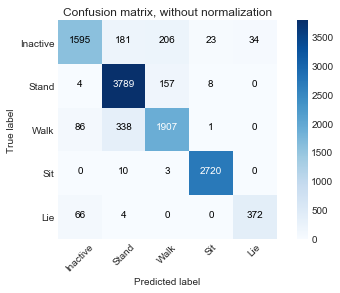

In [13]:
# results
Y_pred_os, score_os = launch.evaluation(model, X_test, Y_test, filepath, save_model_name)
# save for future use
Y_true = Y_test
# confusion matrix
cnf_matrix = confusion_matrix(Y_test, Y_pred_os)
np.set_printoptions(precision=2)
sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=classes, title='Confusion matrix, without normalization')

## Binary classification for activity detection
Here all the "activity" classes are labelled with 1, while the inactivity class remains labelled with 0. As before, in the following cell are perfomed in order:
- preprocessing;
- model selection;
- model compilation;
- training.

In [16]:
model, X_test, Y_test, filepath, save_model_name = launch.cascade_detection(subject,
                                                                            task,
                                                                            model_name,
                                                                            data_folder,
                                                                            window_size=window_size,
                                                                            stride=stride,
                                                                            epochs=epochs,
                                                                            batch_size=batch_size,
                                                                            balcance_classes=balance_classes,
                                                                            GPU=GPU,
                                                                            print_info=print_info)

Model: A_Convolutional_TSD_1 
Location: ./data/models/A_Convolutional_TSD_1.hdf5 

Train on 31422 samples, validate on 11504 samples
Epoch 1/10
31422/31422 [==============================] - 12s 395us/step - loss: 0.2416 - acc: 0.9591 - val_loss: 0.2510 - val_acc: 0.9465

Epoch 00001: val_loss improved from inf to 0.25097, saving model to ./data/models/A_Convolutional_TSD_1.hdf5
Epoch 2/10
31422/31422 [==============================] - 10s 328us/step - loss: 0.0828 - acc: 0.9738 - val_loss: 0.2682 - val_acc: 0.9408

Epoch 00002: val_loss did not improve
Epoch 3/10
31422/31422 [==============================] - 10s 331us/step - loss: 0.0707 - acc: 0.9771 - val_loss: 0.2453 - val_acc: 0.9479

Epoch 00003: val_loss improved from 0.25097 to 0.24527, saving model to ./data/models/A_Convolutional_TSD_1.hdf5
Epoch 4/10
31422/31422 [==============================] - 11s 336us/step - loss: 0.0643 - acc: 0.9792 - val_loss: 0.2514 - val_acc: 0.9465

Epoch 00004: val_loss did not improve
Epoch 5/1

### Results


Results for last A_Convolutional_TSD_1:
              precision    recall  f1-score   support

          0       0.91      0.79      0.84      2039
          1       0.96      0.98      0.97      9465

avg / total       0.95      0.95      0.95     11504



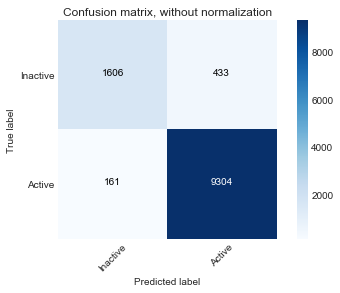

In [18]:
# results
Y_pred_ad, score_ad = launch.evaluation(model, X_test, Y_test, filepath, save_model_name)
# confusion matrix
cnf_matrix = confusion_matrix(Y_test, Y_pred_ad)
np.set_printoptions(precision=2)
sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=["Inactive","Active"], title='Confusion matrix, without normalization')

## Classification without null class: Two Steps - classification
Here all the "activity" classes are kept while the inactivity class is discarded during preprocessing. Again, in the following cell are perfomed in order:
- preprocessing;
- model selection;
- model compilation;
- training.

In [21]:
model, X_test, Y_test, filepath, save_model_name = launch.cascade_classification(subject,
                                                                                 task,
                                                                                 model_name,
                                                                                 data_folder,
                                                                                 window_size=window_size,
                                                                                 stride=stride,
                                                                                 epochs=epochs,
                                                                                 batch_size=batch_size,
                                                                                 balcance_classes=balance_classes,
                                                                                 GPU=GPU,
                                                                                 print_info=print_info)

Model: A_Convolutional_TSC_1 
Location: ./data/models/A_Convolutional_TSC_1.hdf5 

Train on 27948 samples, validate on 9465 samples
Epoch 1/10
27948/27948 [==============================] - 12s 426us/step - loss: 0.4507 - acc: 0.8803 - val_loss: 0.2899 - val_acc: 0.9287

Epoch 00001: val_loss improved from inf to 0.28985, saving model to ./data/models/A_Convolutional_TSC_1.hdf5
Epoch 2/10
27948/27948 [==============================] - 10s 343us/step - loss: 0.2348 - acc: 0.9082 - val_loss: 0.2574 - val_acc: 0.9392

Epoch 00002: val_loss improved from 0.28985 to 0.25735, saving model to ./data/models/A_Convolutional_TSC_1.hdf5
Epoch 3/10
27948/27948 [==============================] - 10s 341us/step - loss: 0.2133 - acc: 0.9176 - val_loss: 0.2566 - val_acc: 0.9398

Epoch 00003: val_loss improved from 0.25735 to 0.25656, saving model to ./data/models/A_Convolutional_TSC_1.hdf5
Epoch 4/10
27948/27948 [==============================] - 10s 346us/step - loss: 0.1984 - acc: 0.9231 - val_loss:

### Results


Results for best A_Convolutional_TSC_1:
              precision    recall  f1-score   support

          0       0.94      0.92      0.93      3958
          1       0.86      0.90      0.88      2332
          2       1.00      1.00      1.00      2733
          3       1.00      0.88      0.94       442

avg / total       0.94      0.94      0.94      9465



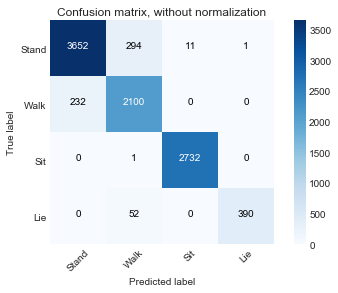

In [22]:
# results
Y_pred_ac, score_ac = launch.evaluation(model, X_test, Y_test, filepath, save_model_name)
# confusion matrix
cnf_matrix = confusion_matrix(Y_test, Y_pred_ac)
np.set_printoptions(precision=2)
sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=classes[1:], title='Confusion matrix, without normalization')

For comparison purposes, the best F1-scores of the three classifications performed above are saved in the variables: 'score_OS', 'score_TSD', 'score_TSC'. These will be plotted later, to be compared with the cascade approach implemented next.
## Cascade of detection and classification
For the evaluation of this approach, the model previously trained are fine: the classification model in particular is trained on the "correct" training set, but then makes its prediction on data coming from the detector. For this part we need some results from the previous code:
- true labels, which correspond to those obtained with the preprocessing of the One Shot classification model ('Y_true');
- predicted labels, by the One Shot classification model ('Y_OS');
- detector predictions on test data, which need to be passed to the second stage of the cascade ('Y_det');
- classification model, which is the last one that has been used ('model').

In the following cell true labels are recalled, the detection model is loaded and used to predict the labels on the test set and, finally, the predictions are used to perform a further classification. Once the predictions are made, they are compared to the true labels: note that to this end, classification predictions need to be inserted in an array containing the detection predictions.

In [24]:
# print info on previous predictions
print("Y_true:  Shape:", Y_true.shape, " Labels:", np.unique(Y_true),
     "\nY_OS:    Shape:", Y_OS.shape, " Labels:", np.unique(Y_OS),
     "\nY_det:   Shape:", Y_det.shape, " Labels:", np.unique(Y_det),
     "\nY_pred:  Shape:", Y_pred.shape, "  Labels:", np.unique(Y_pred))

Y_true:  Shape: (11504,)  Labels: [0 1 2 3 4] 
Y_OS:    Shape: (11504,)  Labels: [0 1 2 3 4] 
Y_det:   Shape: (11504,)  Labels: [0 1] 
Y_pred:  Shape: (9465,)   Labels: [0 1 2 3]


Keep in mind that Y_pred, the predictions by the classifier without the null class, should have label values starting from 1, thus a manual correction will be needed.

In [25]:
# get test set
if subject == 23:
    X_test = preprocessing.loadDataMultiple(label=label,
                                            folder=data_folder,
                                            window_size=window_size,
                                            stride=stride,
                                            make_binary=False,
                                            null_class=True,
                                            print_info=print_info)[2]
else:
    X_test = preprocessing.loadData(subject=subject,
                                    label=label,
                                    folder=data_folder,
                                    window_size=window_size,
                                    stride=stride,
                                    make_binary=False,
                                    null_class=True,
                                    print_info=print_info)[2]

Here a mask is used to select all the windows where activity is detected. Note that this number of windows can be different from the number of non-zero labels (which correspond to the shape of Y_pred, reported above).

In [32]:
# mask
mask = (Y_pred_ad == 1)
print("Mask shape:", mask.shape, "\nDetected activities:", np.sum(mask))

Mask shape: (11504,) 
Detected activities: 9737


In [27]:
activity_windows = X_test[mask, :, :]
# reshaping for 2D convolution
if model_name == "Convolutional2DRecurrent":
    activity_windows = activity_windows.reshape(activity_windows.shape[0], window_size, X_test.shape[1], 1)
print("New test set has shape:", activity_windows.shape)

New test set has shape: (9737, 15, 110)


The classification previously trained is now used to predict the classes on the new test set.

In [33]:
Y_casc_ac = model_best.predict_classes(activity_windows) + 1
print("Y_casc_ac:  Shape:", Y_casc_ac.shape, " Labels:", np.unique(Y_casc_ac))

Y_casc_ac:  Shape: (9737,)  Labels: [1 2 3 4]


These predictions are inserted back in the detector's values, substituting these new labels to the ones with value 1. The locations to be modified are still those flagged by the 'mask'.

In [35]:
Y_casc = Y_pred_ad
Y_casc[mask] = Y_casc_ac
print("Y_casc:    Shape:", Y_casc.shape, " Labels:", np.unique(Y_casc))

Y_casc:    Shape: (11504,)  Labels: [0 1 2 3 4]


             precision    recall  f1-score   support

          0       0.91      0.79      0.84      2039
          1       0.91      0.92      0.92      3958
          2       0.80      0.87      0.83      2332
          3       0.99      1.00      0.99      2733
          4       0.85      0.85      0.85       442

avg / total       0.90      0.90      0.90     11504



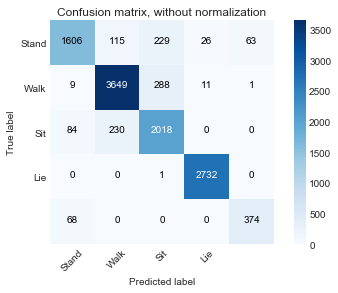

In [36]:
print(classification_report(Y_true, Y_casc))
cnf_matrix = confusion_matrix(Y_true, Y_casc)
np.set_printoptions(precision=2)
sns.set_style("dark")
plt.figure()
utils.plot_confusion_matrix(cnf_matrix, classes=classes[1:], title='Confusion matrix, without normalization')

## Comparison between the two pipelines

In [37]:
print("One-Shot weighted f1-score:  ", score_os)
print("Two-Steps weighted f1-score: ", f1_score(Y_true, Y_casc, average='weighted'))
print("With partials:\n\t\tDetection:     ",score_ad,"\n\t\tClassification:", score_ac)

One-Shot weighted f1-score:   0.9012897065473569
Two-Steps weighted f1-score:  0.9019916810886153
With partials:
		Detection:      0.9468864419539629 
		Classification: 0.9378570037428234


# The end